### Transfer Learning

Transfer learning refers to using a pre-trained model, modify slightly, in CNN ususally the last layer(s), and train with new data set for a small number of epochs to fit the data for new problems.

In this unit we explore 3 things:
- ImageFolder  
- Scheduler  
- Transfer Learning

And for the ImageFolder part to work, we need this specific structure:

In [1]:
# Set up the usual, needed transforms, get data and dataloader, show some samples, and training. 
# Note we are not building our own model, we are going to use pre-trained

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
# Not sure why std is 0.25. Mean of 0.5 is because PIL image has value from 0~1

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [3]:
# Set up transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'validate': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [5]:
# Get data and dataloaders
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validate']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'validate']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validate']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


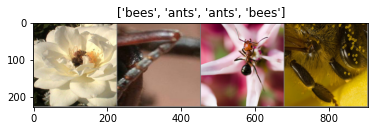

In [8]:
#  Show sample images 

def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # why the transpose again?
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
# Function to train model

def train_model(model, criterion, optimizer, scheduler, num_epoch=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())  # why the deepcopy?
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch, num_epoch - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'validate']:
            if pahse == 'train':
                model.train()  # set model to train mode
            else:
                model.eval()  # set model to evaluation mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = inputs.to(device)
                
                # forward pass
                # track history if only in training mode
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward pass + optimize if only in training mode
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                # get stats
                running_loss += loss.item() * inputs.size(0)  # why size(0)?
                running_corrects += torch.sum(preds == labels.data)  # why labels.data, not just labels?
                
            if phase == 'train':
                scheduler.step()
                
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'validate' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
                    

In [12]:
# Now let's begin transfer learning!!